In [1]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.neighbors import KDTree
from scipy.signal import medfilt as median_filter
from time import sleep
H,W = 360,640
M,N = 8,8

mesh_outlier_subframe_row_count = 4
mesh_outlier_subframe_col_count = 4
spatial_radius = 100
homography_min_number_corresponding_features = 4
temporal_smoothing_radius = 30
optimization_num_iterations = 200

frame count 447


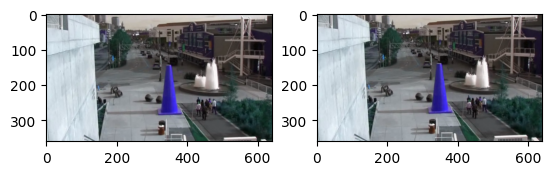

In [2]:
path = 'E:/Datasets/DeepStab_Dataset/unstable/2.avi'
cap = cv2.VideoCapture(path)
frames = []
while True:
    ret,frame = cap.read()
    if not ret: break
    frame = cv2.resize(frame,(W,H))
    frames.append(frame)
cap.release()
frames = np.array(frames, np.uint8)
frame_count = frames.shape[0]
print(f'frame count {frame_count}')
img1 , img2 = frames[100,...], frames[101,...]
plt.subplot(1,2,1)
plt.imshow(img1)
plt.subplot(1,2,2)
plt.imshow(img2)

In [3]:
# Generate grid coordinates
y = np.linspace(0, H - 1, M, dtype=int)
x = np.linspace(0, W - 1, N, dtype=int)
grid_y, grid_x = np.meshgrid(y, x, indexing='ij')
grid_vertices = np.stack([grid_x, grid_y],-1).reshape(-1,2)
print(grid_vertices.shape)

(64, 2)


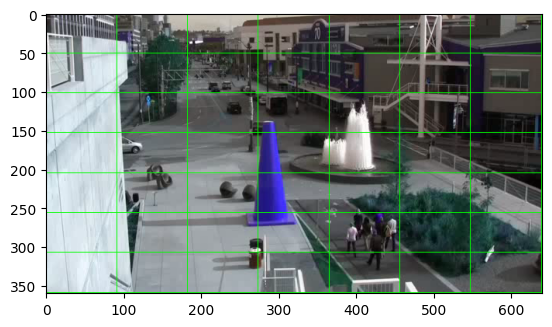

In [4]:
def draw_grid(img):
    top_left = np.stack([grid_x[:-1, :-1], grid_y[:-1, :-1]], axis=-1)
    top_right = np.stack([grid_x[:-1, 1:], grid_y[:-1, 1:]], axis=-1)
    bottom_left = np.stack([grid_x[1:, :-1], grid_y[1:, :-1]], axis=-1)
    bottom_right = np.stack([grid_x[1:, 1:], grid_y[1:, 1:]], axis=-1)
    grid_vertices = np.stack([grid_x, grid_y],-1).reshape(-1,2)
    four_corners = np.stack([top_left, top_right, bottom_left, bottom_right], axis=-2)
    painted = img.copy()
    for i in range(four_corners.shape[0]):
        for j in range(four_corners.shape[1]):
            # Get the vertices of the current grid
            vertices = four_corners[i, j]

            # Draw the rectangle for the current grid
            cv2.rectangle(painted, tuple(vertices[0]), tuple(vertices[3]), (0, 255, 0), 1)
    return painted
plt.imshow(draw_grid(frames[0,...]))

In [6]:
feature_detector = cv2.FastFeatureDetector_create()
# Lucas-Kanade optical flow parameters
lk_params = dict(winSize=(15, 15), maxLevel=2, criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

cv2.namedWindow('window',cv2.WINDOW_NORMAL)
grid_motion = np.zeros((frame_count - 1, grid_vertices.shape[0],2),dtype = np.float32)
lambda_coeff = np.ones((frame_count -1), dtype = np.float32)
for frame_idx in range(frame_count - 1):
    prev = frames[frame_idx,...]
    prev_gray = cv2.cvtColor(prev, cv2.COLOR_BGR2GRAY)
    curr = frames[frame_idx + 1, ...]
    curr_gray = cv2.cvtColor(curr, cv2.COLOR_BGR2GRAY)
    #detect SIFT keypoints by sub_frames with ransac outlier removal
    frame_height, frame_width = H, W
    subframe_width = math.ceil(frame_width / mesh_outlier_subframe_col_count)
    subframe_height = math.ceil(frame_height / mesh_outlier_subframe_row_count)

    prev_features_by_subframe = []
    curr_features_by_subframe = []
    for subframe_left_x in range(0, frame_width, subframe_width):
            for subframe_top_y in range(0, frame_height, subframe_height):
                prev_subframe = prev_gray[subframe_top_y:subframe_top_y+subframe_height,
                                           subframe_left_x:subframe_left_x+subframe_width]
                curr_subframe = curr_gray[subframe_top_y:subframe_top_y+subframe_height,
                                         subframe_left_x:subframe_left_x+subframe_width]
                subframe_offset = [subframe_left_x, subframe_top_y]
                #detect keypoints in previous subframe
                kpts = feature_detector .detect(prev_subframe)
                kpts = np.array([kpt.pt for kpt in kpts], dtype=np.float32)
                if len(kpts) > 0:
                    correspondances, status, _ = cv2.calcOpticalFlowPyrLK(prev_subframe, curr_subframe, kpts, None, **lk_params)
                    kpts_good = kpts[status[:,0] == 1]
                    correspondances_good = correspondances[status[:,0] == 1]
                    #filter outliers with local homography ransac
                    if len(kpts_good) > homography_min_number_corresponding_features:
                        _, outliers_mask = cv2.findHomography(kpts_good, correspondances_good,
                                                cv2.RANSAC, ransacReprojThreshold=5.0)
                        outliers_mask = outliers_mask.flatten().astype(dtype = bool)
                        kpts_good = kpts_good[outliers_mask]
                        correspondances_good = correspondances_good[outliers_mask]
                    kpts_good += subframe_offset
                    correspondances_good += subframe_offset
                    
                    prev_features_by_subframe.append(kpts_good)
                    curr_features_by_subframe.append(correspondances_good)
    prev_features = np.concatenate(prev_features_by_subframe)
    curr_features = np.concatenate(curr_features_by_subframe)
    drawn = draw_grid(prev)
    for (x,y) in prev_features:
        cv2.circle(drawn,(int(x),int(y)), radius = 2 ,color = [0,0,255])  
    if len(prev_features_by_subframe) < homography_min_number_corresponding_features:
        continue
    #initialize motion with global homography
    mat, _ = cv2.findHomography(prev_features, curr_features)
    dx = mat[0, 2].astype(np.float32)
    dy = mat[1, 2].astype(np.float32)
    warped_vertices = np.matmul(mat , np.concatenate([grid_vertices, np.ones((grid_vertices.shape[0], 1))], axis = 1).T)
    warped_vertices = (warped_vertices[:2,...] / warped_vertices[2,...]).T
    grid_motion[frame_idx,...] = warped_vertices - grid_vertices
    #grid_motion[frame_idx,:,0] += dx / W
    #grid_motion[frame_idx,:,1] += dy / H
    #predict lambda
    translational_element  = np.sqrt((dx / W)**2 + (dy / H)**2)
    l1 = -1.93 * translational_element + 0.95
    affine_part = mat.copy()
    affine_part[2,:] = [0, 0, 1]
    eigenvalues = np.abs(np.linalg.eigvals(affine_part))
    eigenvalues = sorted(eigenvalues,reverse= True)
    affine_component = eigenvalues[0] / eigenvalues[1]
    l2 = 5.83 * affine_component - 4.88
    lambda_coeff[frame_idx] = max(min(l1,l2),0)
    # calculate vertex flows
    kpt_flow = curr_features - prev_features
    img_center= (cx,cy) = (W//2, H//2)
    vector_from_center_to_kpt = np.array([[xx - cx, yy - cy] for (xx,yy) in prev_features])
    for vertex_idx, vertex in enumerate(grid_vertices):
        (px,py) = vertex
        vector_from_vertex_to_center = np.array([cx - px, cy - py ])
        vector_from_vertex_to_kpt = vector_from_vertex_to_center + vector_from_center_to_kpt
        distances = np.linalg.norm(vector_from_vertex_to_kpt, axis = 1, keepdims = False)
        indices = np.where(distances <= spatial_radius)
        if len(indices) > 10: #only propagate motion if there are at least 10 nearby kpts
            nearby_kpt_flows = kpt_flow[indices,:]
            #apply f1 median filter to nearby flows
            kernel_size = len(indices) // 8 + 1
            if kernel_size % 2 == 0: # Ensure 'kernel_size' is odd
                kernel_size += 1
            filtered_dx = median_filter(nearby_kpt_flows[:,0], kernel_size = kernel_size)
            filtered_dy = median_filter(nearby_kpt_flows[:,1], kernel_size= kernel_size)
            filtered_flows = np.stack([filtered_dx, filtered_dy], axis = 1)
            mean_flow = np.mean(filtered_flows, axis = 0)
            grid_motion[frame_idx, vertex_idx,: ] += mean_flow
    #apply f2 filter to overall grid flow
    filtered_dx = median_filter(grid_motion[frame_idx,:,0], kernel_size= 15)
    filtered_dy = median_filter(grid_motion[frame_idx,:,1], kernel_size= 15)
    grid_motion[frame_idx,...] = np.stack([filtered_dx, filtered_dy], axis = 1)
    for (x1,y1), (dx,dy) in zip(grid_vertices[1:,...], grid_motion[frame_idx,1:,:]):
        angle = np.arctan2(dy, dx)
        magnitude = np.sqrt(dx **2 + dy ** 2)
        magnitude = np.floor(magnitude * 10).astype(np.int32)
        x2 = np.floor(x1 + magnitude * np.cos(angle)).astype(np.int32)
        y2 = np.floor(y1 + magnitude * np.sin(angle)).astype(np.int32)
        start_point = (x1,y1)
        end_point = (x2,y2)
        drawn = cv2.arrowedLine(drawn, start_point, end_point, 
                                        (0, 165, 255), 2)
    cv2.imshow('window',drawn)
    if cv2.waitKey(1) & 0xFF == ord(' '):
        break  
cv2.destroyAllWindows()

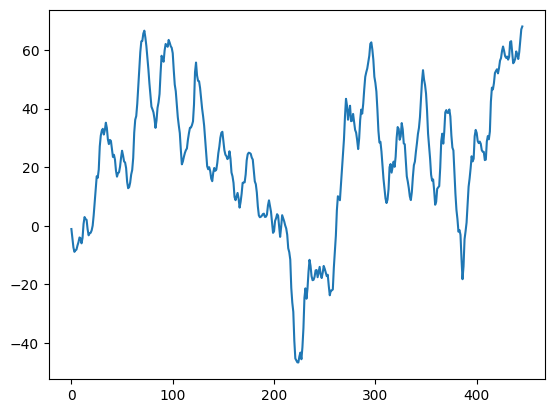

In [7]:
grid_paths = np.cumsum(grid_motion, axis = 0)
plt.plot(grid_paths[:,M*N//2,0])

In [8]:
lambda_adaptive = lambda_coeff

In [9]:
def optimize_path(path,lambda_weights):
    row_indexes, col_indexes = np.indices((frame_count - 1 , frame_count - 1))
    regularization_weights = np.exp(
                -np.square((3 / temporal_smoothing_radius) * (row_indexes - col_indexes)))
    adaptive_weights = lambda_weights
    combined_adaptive_regularization_weights = np.matmul(np.diag(adaptive_weights), regularization_weights)
    off_diagonal_coefficients = -2 * combined_adaptive_regularization_weights # 
    on_diagonal_coefficients = 1 + 2 * np.sum(combined_adaptive_regularization_weights, axis=1)

    # set coefficients to 0 for appropriate t, r; see https://stackoverflow.com/a/36247680
    off_diagonal_mask = np.zeros(off_diagonal_coefficients.shape)
    for i in range(-temporal_smoothing_radius, temporal_smoothing_radius + 1):
        off_diagonal_mask += np.diag(np.ones(frame_count -1 - abs(i)), i)
    off_diagonal_coefficients = np.where(off_diagonal_mask, off_diagonal_coefficients, 0)

    grid_paths = path
    stable_grid_paths = np.zeros_like(grid_paths)
    for idx in range(M*N):
        vertex_unstable_profile = grid_paths[:,idx,:]
        x = vertex_unstable_profile.copy()
        b = vertex_unstable_profile.copy()
        reciprocal_on_diagonal_coefficients_matrix = np.diag(np.reciprocal(on_diagonal_coefficients))

        for _ in range(optimization_num_iterations):
            x = np.matmul(reciprocal_on_diagonal_coefficients_matrix, b - np.matmul(off_diagonal_coefficients, x))
        stable_grid_paths[:,idx,:] = x
    return stable_grid_paths

In [10]:
stable_grid_path_adaptive = optimize_path(grid_paths, lambda_adaptive)
#stable_grid_path_constant_100 = optimize_path(grid_paths, np.full((frame_count -1), 100))

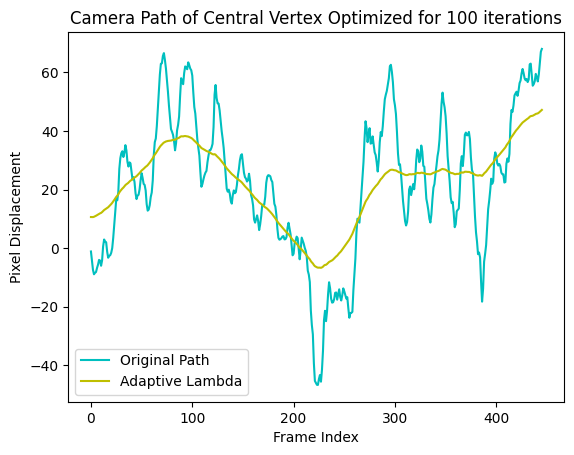

In [11]:
plt.plot(grid_paths[:,M*N//2,0], color = 'c',label = 'Original Path')
plt.plot(stable_grid_path_adaptive[:,M*N//2,0], color = 'y', label = 'Adaptive Lambda')
#plt.plot(stable_grid_path_constant_100[:,M*N//2,0], color = 'r', label = 'Constant Lambda: 100')
plt.title('Camera Path of Central Vertex Optimized for 100 iterations')
plt.xlabel('Frame Index')
plt.ylabel('Pixel Displacement')
plt.legend()
plt.show()

In [12]:
warps = stable_grid_path_adaptive - grid_paths
warps.shape

(446, 64, 2)

In [13]:
#PCA inpaint
import torch
device = 'cuda'
num_components = 20
U = np.load('./principal_components/PC_U.npy')
V = np.load('./principal_components/PC_V.npy')
U1 = np.zeros((num_components, H * W))
V1 = np.zeros((num_components, H * W))
for i in range(0, num_components):
    temp = U[i, ...].reshape((256, 512))
    temp = cv2.resize(temp, (W, H))
    U1[i, ...] = temp.reshape(1, H * W)
    temp = V[i, ...].reshape((256, 512))
    temp = cv2.resize(temp, (W, H))
    V1[i, ...] = temp.reshape(1, H * W)
U = torch.from_numpy(U1).float()
V = torch.from_numpy(V1).float()
base = torch.cat((U, V), 0).t()
base = base.to(device)

def inpaint(mask, flow, device='cuda'):
    flow = flow.permute(0, 2, 3, 1).to(device)
    mask_flat = mask.view(-1).to(device)
    Q = base[mask_flat > 0].to(device)
    flow_flat = flow.view(-1, 2).to(device)
    valid_flow = flow_flat[mask_flat > 0]
    c = torch.matmul(torch.matmul((torch.matmul(Q.t(), Q) + 0.1 * torch.eye(2 * num_components).to(device)).inverse(), Q.t()), valid_flow)
    pca_flow = torch.matmul(base, c)
    pca_flow = pca_flow.view(H, W, 2).unsqueeze(0)
    return pca_flow.permute(0,-1,1,2).cpu()

def show_flow(flow):
    hsv_mask = np.zeros(shape= flow.shape[:-1] +(3,),dtype = np.uint8)
    hsv_mask[...,1] = 255
    mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1],angleInDegrees=True)
    hsv_mask[:,:,0] = ang /2 
    hsv_mask[:,:,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
    rgb = cv2.cvtColor(hsv_mask,cv2.COLOR_HSV2RGB)
    return(rgb)

def warpFlow(img, flow):
    h, w = flow.shape[:2]
    flow = -flow
    flow[:,:,0] += np.arange(w)
    flow[:,:,1] += np.arange(h)[:,np.newaxis]
    warped = cv2.remap(img, flow, None, cv2.INTER_LINEAR, cv2.BORDER_TRANSPARENT)
    return(warped)

In [18]:
# Generate grid coordinates
y = np.linspace(0, H - 1, M, dtype=int)
x = np.linspace(0, W - 1, N, dtype=int)
grid_y, grid_x = np.meshgrid(y, x, indexing='ij')
grid_vertices = np.stack([grid_x, grid_y],-1).reshape(-1,2)
grid_vertices = torch.from_numpy(grid_vertices).float()
mask = torch.zeros((H,W)).float()
mask[grid_vertices[:,1].long(),grid_vertices[:,0].long()] = 1
flows_full_sparse  = torch.zeros((frame_count,2,H,W)).float()
flows_full_sparse[:-1,:,grid_vertices[:,1].long(),grid_vertices[:,0].long()] = torch.from_numpy(warps).permute(0,2,1).float()

In [19]:
print('\ninpainting flows')
inpainted_flows = torch.zeros_like(flows_full_sparse)
cv2.namedWindow('window',cv2.WINDOW_NORMAL)
for idx in range(inpainted_flows.shape[0]):
    inpainted = inpaint(mask,flows_full_sparse[idx : idx + 1,...])
    inpainted_flows[idx:idx+1,...] = inpainted
    inpainted = inpainted.squeeze(0).permute(1,2,0).numpy()
    cv2.imshow('window',show_flow(inpainted))
    if cv2.waitKey(1) & 0xFF == ord(' '):
        break
cv2.destroyAllWindows()


inpainting flows


In [20]:
print('\nwarping frames and saving video')
cap = cv2.VideoCapture('E:/Datasets/DeepStab_Dataset/unstable/2.avi')
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('./stable_2.avi', fourcc, 30.0, (W, H))
cv2.namedWindow('window',cv2.WINDOW_NORMAL)
idx = 0
while True:
    ret,img = cap.read()
    if not ret:
        break
    idx += 1
    try:
        warped = warpFlow(img, inpainted_flows[idx,...].permute(1,2,0).numpy())
    except IndexError:
        pass
    out.write(warped)
    cv2.imshow('window',warped)
    sleep(1/30)
    if cv2.waitKey(1) & 0xFF == ord(' '):
        break
cv2.destroyAllWindows()
out.release()
cap.release()


warping frames and saving video
